In [121]:
from pathlib import Path
import torch
import pandas as pd
import stat
import numbers
import pydicom
import numpy as np
from tqdm import tqdm
from collections import Counter
import re
import os
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import json
import seaborn as sns
import torchio as tio
import torchvision.transforms.functional as TF
import random

In [70]:
import sys
sys.path.insert(1, '/home/buehlern/Documents/Masterarbeit/models')
from src.data.mri_datamodule import MRIDataModule

In [11]:
sns.set(style="whitegrid", font_scale=1.2)

In [2]:
Path().resolve()

PosixPath('/home/buehlern/Documents/Masterarbeit/notebooks')

In [3]:
df_loc = Path('../data/df_min.pkl')
df = pd.read_pickle(df_loc)

In [188]:
df['bodypart'] = df['bodypart'].str.replace('rips', 'ribs', regex=False)

In [189]:
df

patientid                                               path  \
0       -0XIAZI2mBM  /home/buehlern/neocortex-nas/shared/Skelett/BW...   
1       -0XIAZI2mBM  /home/buehlern/neocortex-nas/shared/Skelett/BW...   
2       -1qIJOjCmUA  /home/buehlern/neocortex-nas/shared/Skelett/BW...   
3       -1qIJOjCmUA  /home/buehlern/neocortex-nas/shared/Skelett/BW...   
4       -1qIJOjCmUA  /home/buehlern/neocortex-nas/shared/Skelett/BW...   
...             ...                                                ...   
639872  zzYDEupARTA  /home/buehlern/neocortex-nas/shared/Skelett/SG...   
639873  zztrIVB0lEM  /home/buehlern/neocortex-nas/shared/Skelett/SG...   
639874  zztrIVB0lEM  /home/buehlern/neocortex-nas/shared/Skelett/SG...   
639875  zzuYHa4Yo7I  /home/buehlern/neocortex-nas/shared/Skelett/SG...   
639876  zzuYHa4Yo7I  /home/buehlern/neocortex-nas/shared/Skelett/SG...   

       pixelarr_shape  inverted bodypart fracture foreignmaterial     x     y  \
0        (2947, 1140)     False   tspine      NaN             NaN  2947  1140   
1        (3001, 2220)     False   tspine      NaN             NaN  3001  2220   
2        (2903, 1267)     False   tspine      NaN             NaN  2903  1267   
3        (2622, 1132)     False   tspine      NaN             NaN  2622  1132   
4        (2834, 1261)     False   tspine      NaN             NaN  2834  1261   
...               ...       ...      ...      ...             ...   ...   ...   
639872   (3056, 1250)      True    ankle      NaN             NaN  3056  1250   
639873    (1654, 960)     False    ankle      NaN             NaN  1654   960   
639874    (1485, 831)     False    ankle      NaN             NaN  1485   831   
639875    (1791, 880)     False    ankle      NaN             NaN  1791   880   
639876   (1685, 1081)     False    ankle      NaN             NaN  1685  1081   

        bin_x  bin_y  pad_x  pad_y  
0        3072   1152   2976   1152  
1        3072   2304   3024   2256  
2        3072   1536   2928   1296  
3        2688   1152   2640   1152  
4        3072   1536   2880   1296  
...       ...    ...    ...    ...  
639872   3072   1536   3072   1296  
639873   1920   1152   1680    960  
639874   1536   1152   1488    864  
639875   1920   1152   1824    912  
639876   1920   1152   1728   1104  

[639877 rows x 13 columns]

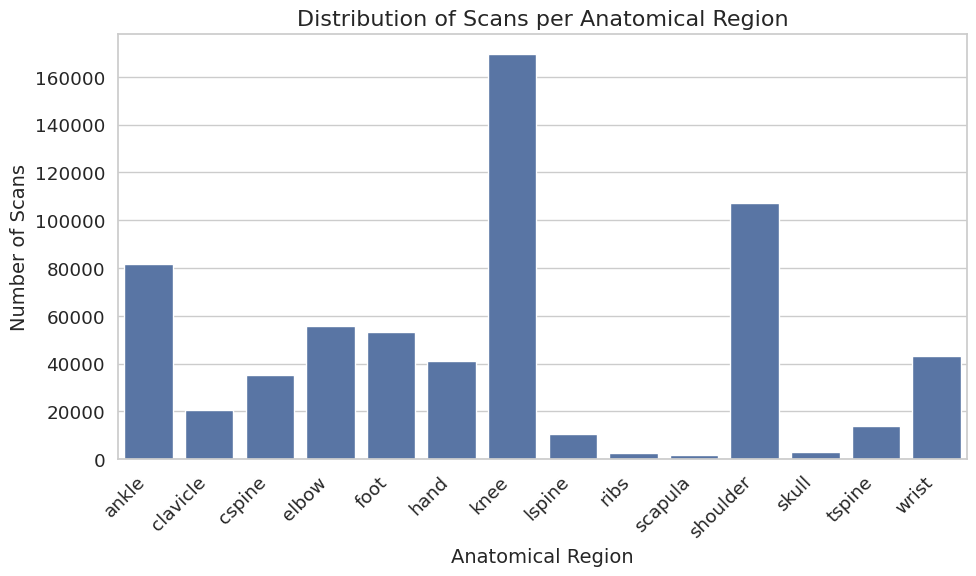

In [190]:
bodypart_counts = df['bodypart'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
sns.barplot(x=bodypart_counts.index, y=bodypart_counts.values)
plt.xlabel("Anatomical Region", fontsize=14)
plt.ylabel("Number of Scans", fontsize=14)
plt.title("Distribution of Scans per Anatomical Region", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("export/bodypart_histogram.png", dpi=300)
plt.show()

x cutoff points: [ 246. 1543. 2002. 2438. 3072.]
y cutoff points: [ 219. 1117. 1417. 1852. 3071.]


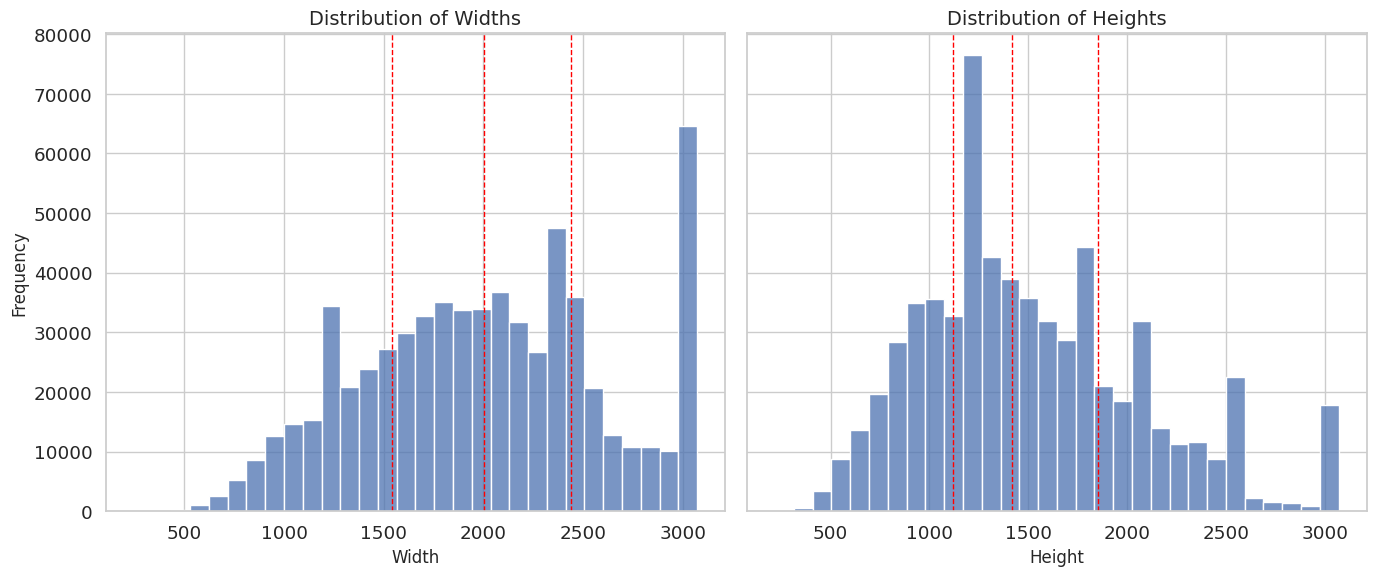

In [30]:
df[['x', 'y']] = df['pixelarr_shape'].tolist()

x_bins = np.percentile(df['x'], [0, 25, 50, 75, 100])
y_bins = np.percentile(df['y'], [0, 25, 50, 75, 100])

print("x cutoff points:", x_bins)
print("y cutoff points:", y_bins)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Width histogram
sns.histplot(df['x'], bins=30, kde=False, ax=axes[0])
axes[0].set_title("Distribution of Widths", fontsize=14)
axes[0].set_xlabel("Width", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

for q in x_bins[1:-1]:
    axes[0].axvline(q, linestyle='--', color='red', linewidth=1)

# Height histogram
sns.histplot(df['y'], bins=30, kde=False, ax=axes[1])
axes[1].set_title("Distribution of Heights", fontsize=14)
axes[1].set_xlabel("Height", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)

for q in y_bins[1:-1]:
    axes[1].axvline(q, linestyle='--', color='red', linewidth=1)

plt.tight_layout()
plt.savefig("export/resolution_histogram.png", dpi=300)
plt.show()

In [39]:
def pad_to_bin(size, bins=[1152, 1536, 1920, 2304, 2688, 3072]):
    # expects bins to be sorted
    for bin_size in bins:
        if size <= bin_size:
            return bin_size
    assert(False)

def pad_to(size, patch_size=48):
    return int(np.ceil(size / patch_size) * patch_size)

df['bin_x'] = df['x'].apply(lambda x: pad_to_bin(x))
df['bin_y'] = df['y'].apply(lambda y: pad_to_bin(y))

df['pad_x'] = df['x'].apply(lambda x: pad_to(x))
df['pad_y'] = df['y'].apply(lambda y: pad_to(y))

raw_pixels = (df['x'] * df['y']).sum()
pad_pixels = (df['pad_x'] * df['pad_y']).sum()
pad_tokens = pad_pixels / 48**2
bin_pixels = (df['bin_x'] * df['bin_y']).sum()
bin_tokens = bin_pixels / 48**2
fix_pixels = 3072 * 3072 * len(df)
fix_tokens = fix_pixels / 48**2

print("Raw pixels", raw_pixels)
print("Padded pixels", pad_pixels, "Padded tokens", pad_tokens)
print("Binned pixels", bin_pixels, "Binned tokens", bin_tokens)
print("Fixed size pixels", fix_pixels, "Fixed size tokens", fix_tokens)

print("Padded/Raw Ratio", pad_pixels / raw_pixels)
print("Binned/Pad Ratio", bin_pixels / pad_pixels)
print("Fixed/Pad Ratio", fix_pixels / pad_pixels)
print("Binned/Fixed Ratio", bin_pixels / fix_pixels)
print("Binned/Fixed Compute Ratio", (bin_pixels / fix_pixels)**2)

Raw pixels 2071693646109
Padded pixels 2123526451968 Padded tokens 921669467.0
Binned pixels 2536770650112 Binned tokens 1101028928.0
Fixed size pixels 6038636986368 Fixed size tokens 2620936192.0
Padded/Raw Ratio 1.025019532186311
Binned/Pad Ratio 1.194602802221287
Fixed/Pad Ratio 2.843683430819348
Binned/Fixed Ratio 0.42008994013693257
Binned/Fixed Compute Ratio 0.1764755578042516


In [41]:
df['bodypart'].unique()

array(['tspine', 'clavicle', 'rips', 'skull', 'elbow', 'foot', 'hand',
       'wrist', 'cspine', 'knee', 'lspine', 'scapula', 'shoulder',
       'ankle'], dtype=object)

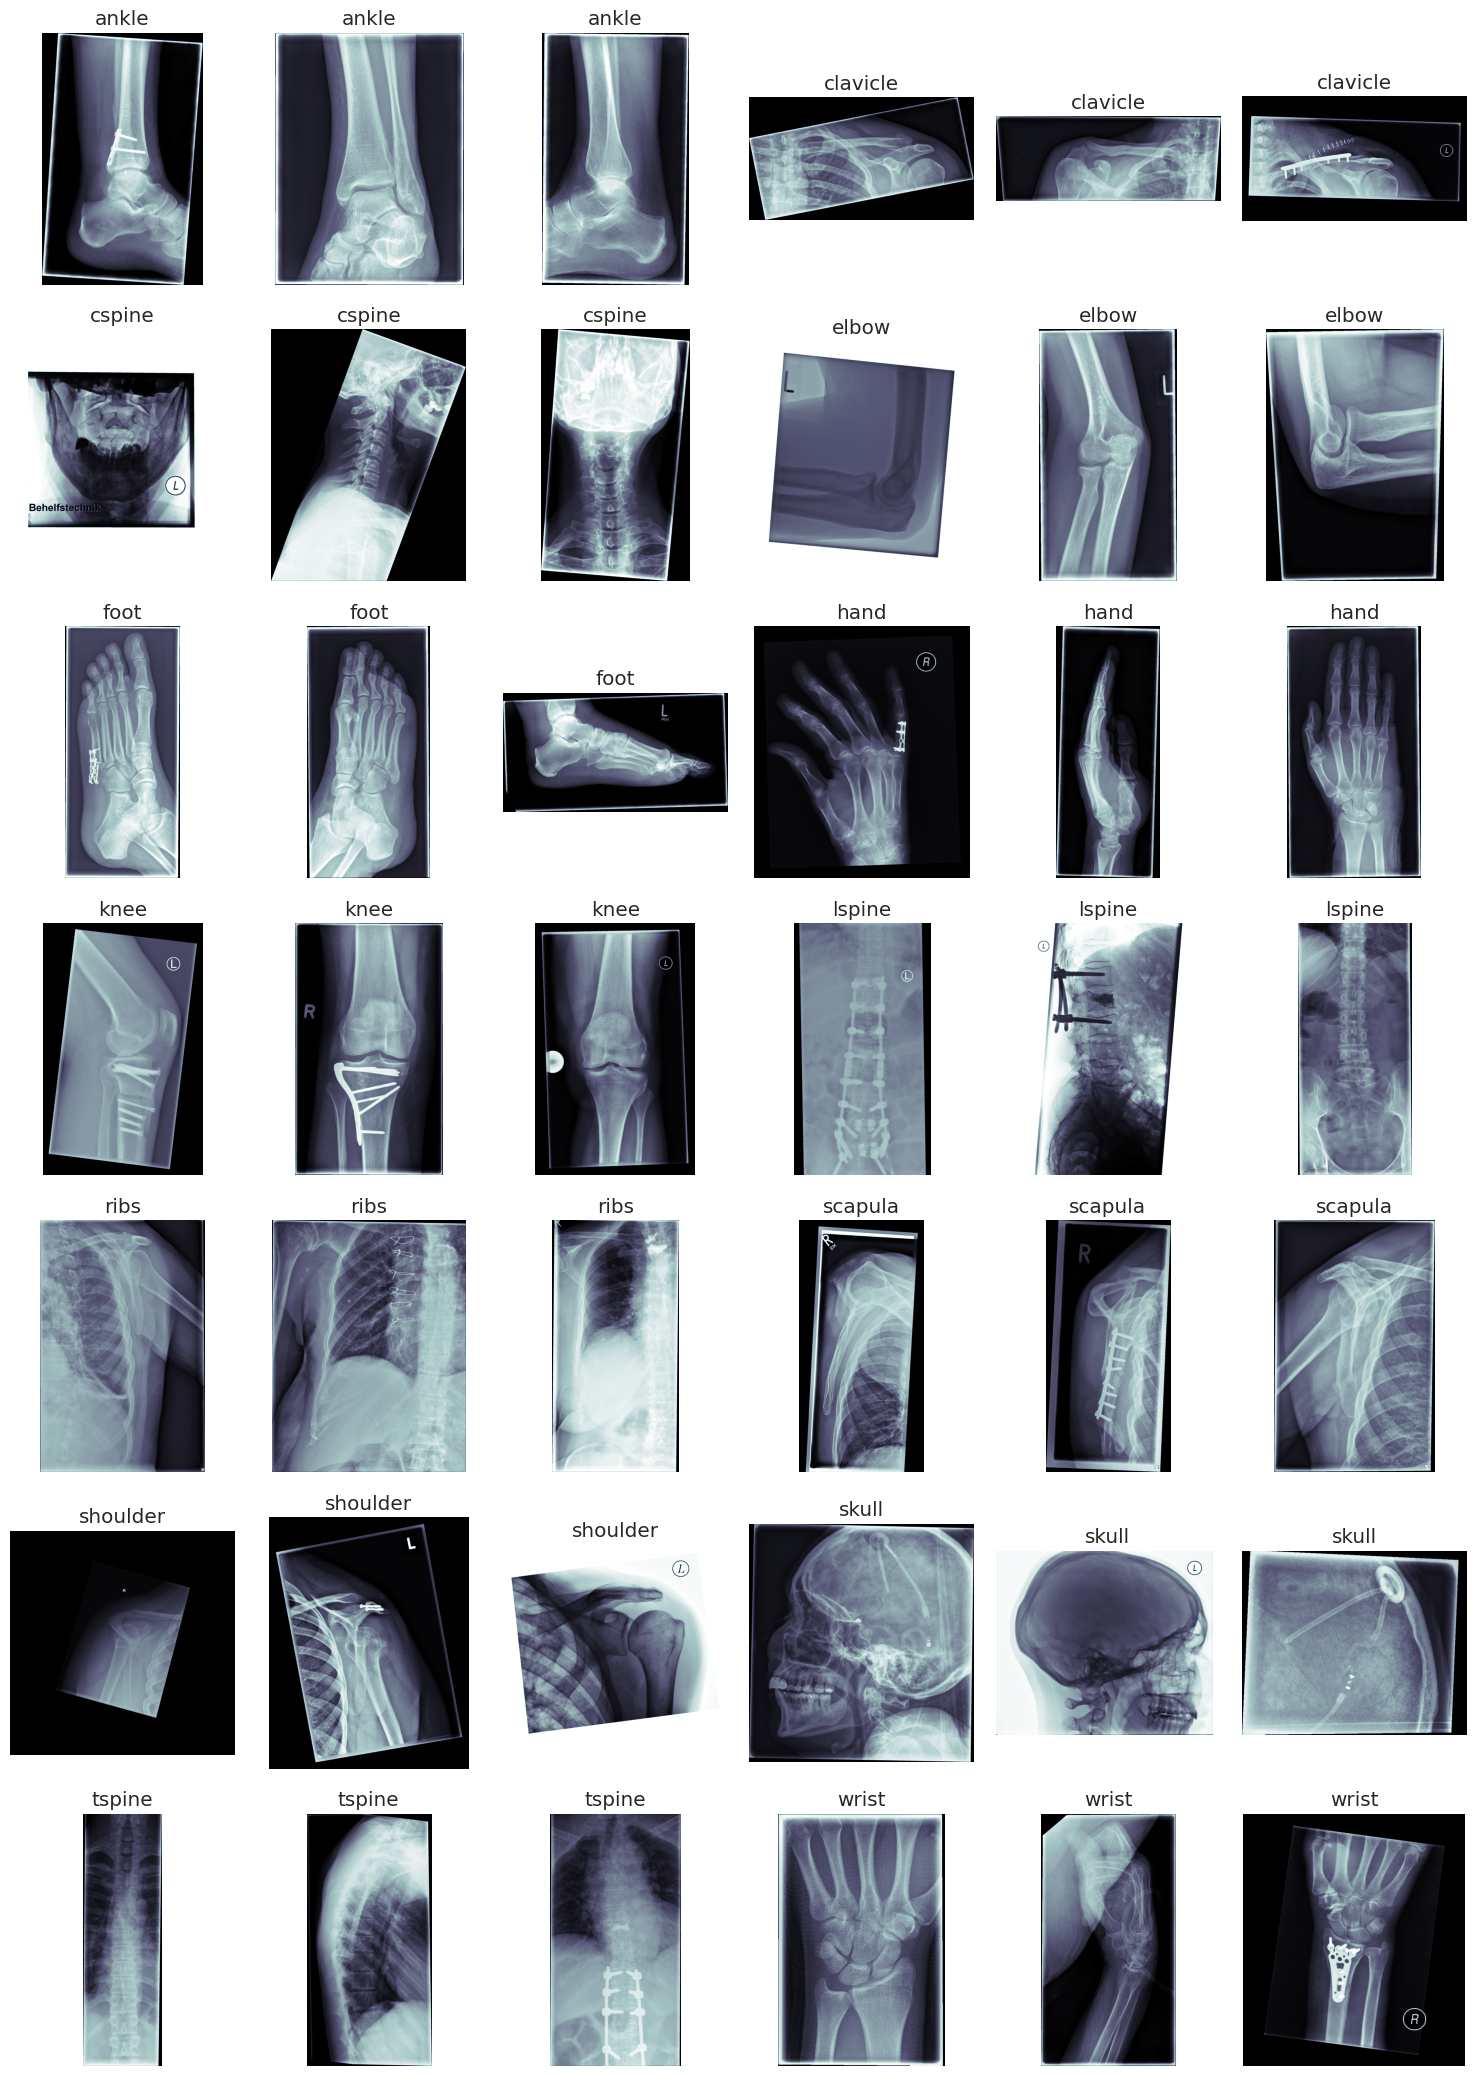

In [191]:
bps = df['bodypart'].unique()
images = df.groupby('bodypart').apply(lambda x: x.sample(3)).reset_index(drop=True)

n = len(bps)
cols = 6
rows = 7

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for i, (index, row) in enumerate(images.iterrows()):
    ax = axes[i // cols, i % cols]
    img = pydicom.dcmread(row['path']).pixel_array
    ax.imshow(img, cmap=plt.cm.bone)
    ax.set_title(row['bodypart'])
    ax.axis('off')

plt.tight_layout()
plt.savefig("export/bodyparts.png", dpi=300)
plt.show()

/tmp/ipykernel_2538732/3306383434.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images = df.groupby('fracture').apply(lambda x: x.sample(5)).reset_index(drop=True)


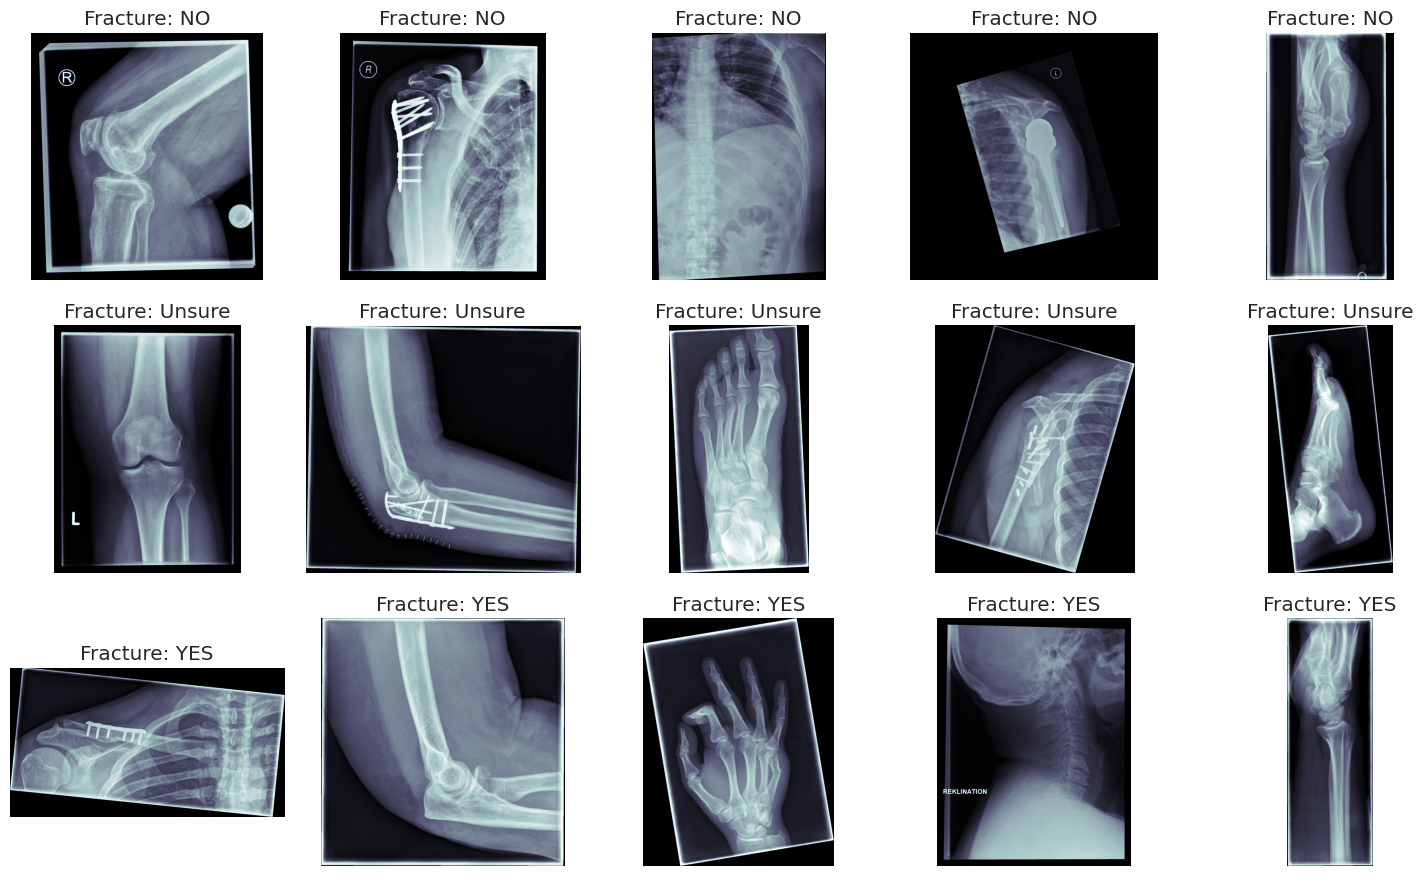

In [63]:
frac = df['fracture'].unique()
images = df.groupby('fracture').apply(lambda x: x.sample(5)).reset_index(drop=True)

cols = 5
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for i, (index, row) in enumerate(images.iterrows()):
    ax = axes[i // cols, i % cols]
    img = pydicom.dcmread(row['path']).pixel_array
    ax.imshow(img, cmap=plt.cm.bone)
    ax.set_title("Fracture: " + row['fracture'])
    ax.axis('off')

plt.tight_layout()
plt.savefig("export/fractures.png", dpi=300)
plt.show()

/tmp/ipykernel_2538732/1898852481.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  images = df_filtered.groupby('foreignmaterial').apply(lambda x: x.sample(5)).reset_index(drop=True)


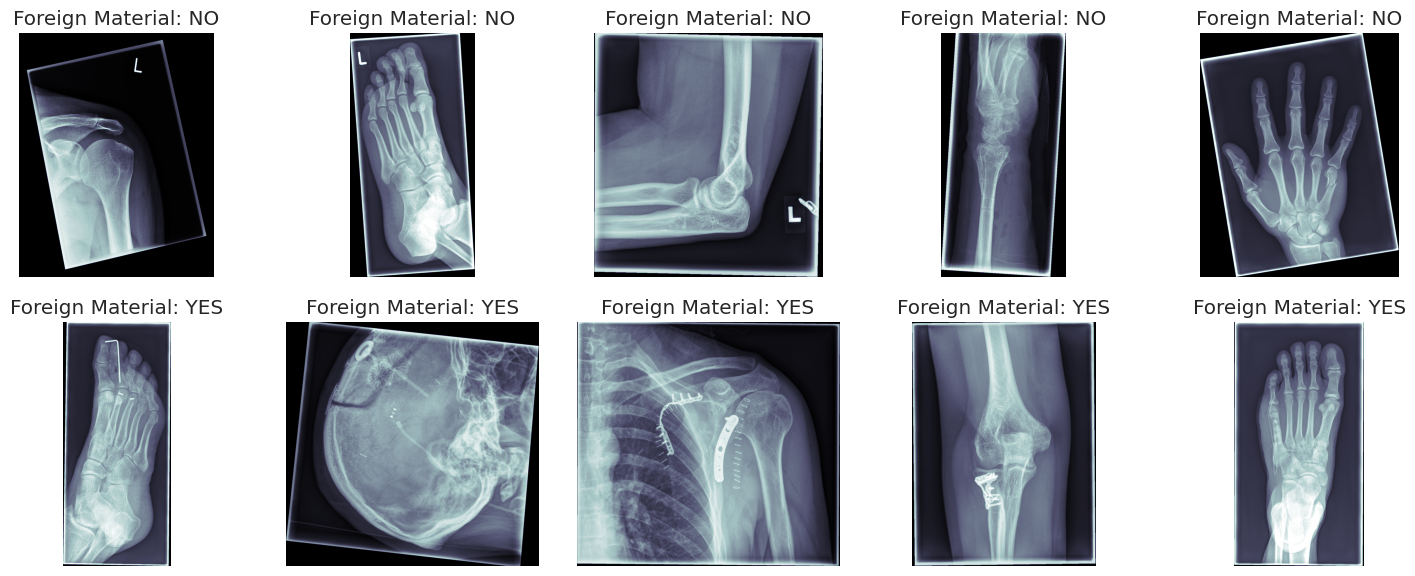

In [68]:
frac = df['foreignmaterial'].unique()
df_filtered = df[df['foreignmaterial'] != 'Unsure']
images = df_filtered.groupby('foreignmaterial').apply(lambda x: x.sample(5)).reset_index(drop=True)

cols = 5
rows = 2

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for i, (index, row) in enumerate(images.iterrows()):
    ax = axes[i // cols, i % cols]
    img = pydicom.dcmread(row['path']).pixel_array
    ax.imshow(img, cmap=plt.cm.bone)
    ax.set_title("Foreign Material: " + row['foreignmaterial'])
    ax.axis('off')

plt.tight_layout()
plt.savefig("export/foreignmaterial.png", dpi=300)
plt.show()

In [71]:
mri_datamodule = MRIDataModule(
    df_name="df_min_ft_test_114",
    label="bodypart",
    pad_to_multiple_of=48,
    #batch_binning="smart",
    #batch_bins=[1152, 1536, 1920, 2304, 2688, 3072],
    batch_size=1,
    num_workers=4,
    persistent_workers=True,
    pin_memory=True,
    val_size=0.05,
    test_size=0.15,
    output_channels=1,
    fix_inverted=True,
    train_augmentations=True
)

Using label bodypart as stratification_target
Initializing MRIDatasetBase...
Loading dataframe from /home/buehlern/Documents/Masterarbeit/data/df_min_ft_test_114.pkl...
MRIDatasetBase(len=114) initialized
Getting train indices...
Done. Train len: 92
Getting val indices...
Done. Val len: 6
Getting test indices...
WARN: Including test data
Done. Test len: 16
Initializing train dataset...
Done.
Initializing val dataset...
Done.
Initializing test dataset...
Done.


In [139]:
val_iter = iter(mri_datamodule.val_dataloader())
item = next(val_iter)
img = torch.einsum('nchw->nhwc', item[0])

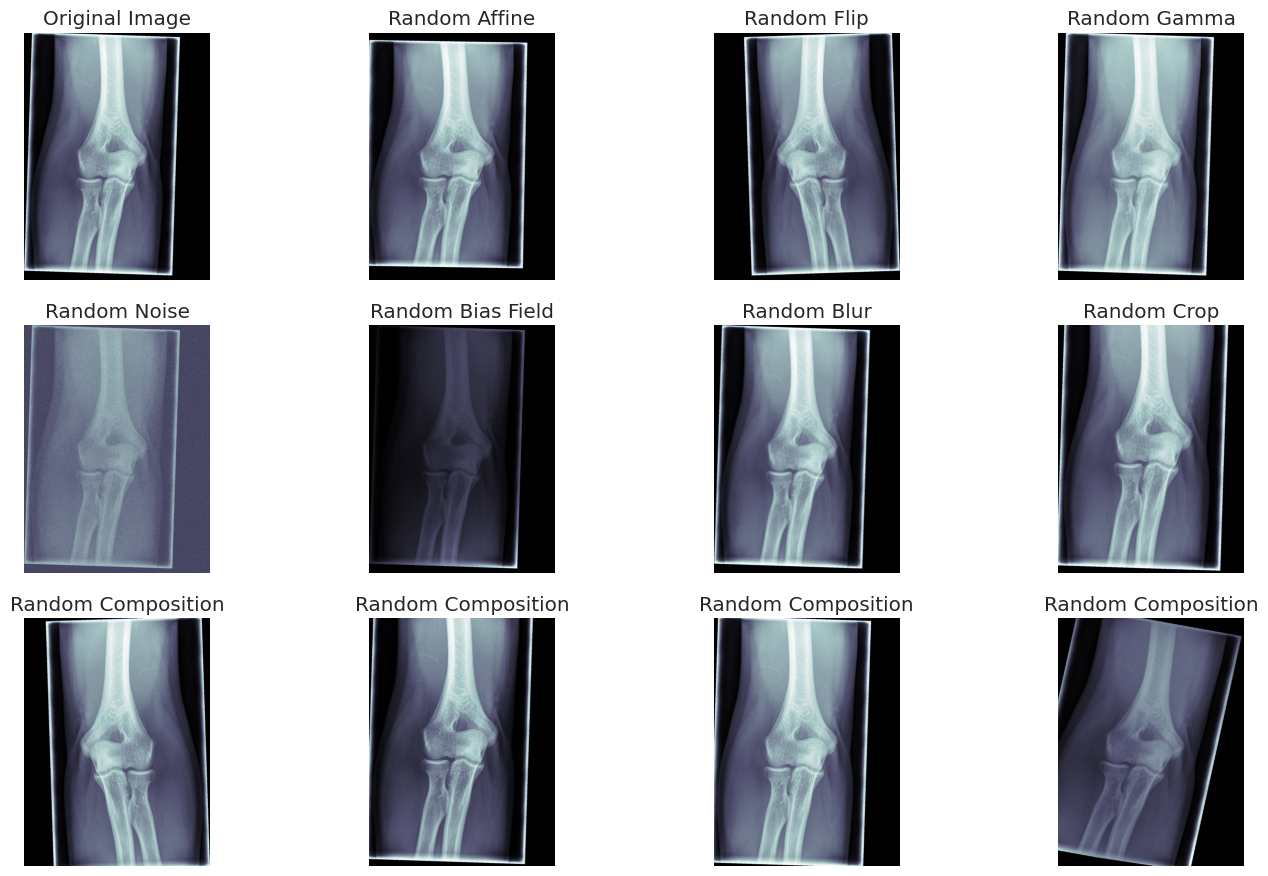

In [149]:
cols = 4
rows = 3

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))

transform = tio.Compose([
    tio.RandomAffine(degrees=20, p=0.5),
    tio.RandomFlip(axes=('P',), flip_probability=0.5),
    tio.RandomGamma(log_gamma=0.5, p=0.5),
    tio.RandomNoise(p=0.3),
    tio.RandomBiasField(p=0.3),
    tio.RandomBlur(p=0.3)])

def random_crop(img):
    img2 = img.squeeze(-1)
    crop_scale = random.uniform(0.9, 1.0)
    _, h, w = img2.shape
    new_h, new_w = int(h * crop_scale), int(w * crop_scale)
    top = random.randint(0, h - new_h)
    left = random.randint(0, w - new_w)
    cropped = img2[:, top:top + new_h, left:left + new_w]
    cropped = TF.resize(cropped, (h, w))
    return cropped.unsqueeze(-1)

ax = axes[0, 0]
ax.imshow(img[0], cmap=plt.cm.bone)
ax.set_title("Original Image")
ax.axis('off')

ax = axes[0, 1]
ax.imshow(tio.RandomAffine(degrees=20)(img)[0], cmap=plt.cm.bone)
ax.set_title("Random Affine")
ax.axis('off')

ax = axes[0, 2]
ax.imshow(tio.RandomFlip(axes=('P',), flip_probability=1)(img)[0], cmap=plt.cm.bone)
ax.set_title("Random Flip")
ax.axis('off')

ax = axes[0, 3]
ax.imshow(tio.RandomGamma(log_gamma=0.5)(img)[0], cmap=plt.cm.bone)
ax.set_title("Random Gamma")
ax.axis('off')

ax = axes[1, 0]
ax.imshow(tio.RandomNoise()(img)[0], cmap=plt.cm.bone)
ax.set_title("Random Noise")
ax.axis('off')

ax = axes[1, 1]
ax.imshow(tio.RandomBiasField()(img)[0], cmap=plt.cm.bone)
ax.set_title("Random Bias Field")
ax.axis('off')

ax = axes[1, 2]
ax.imshow(tio.RandomBlur()(img)[0], cmap=plt.cm.bone)
ax.set_title("Random Blur")
ax.axis('off')

ax = axes[1, 3]
ax.imshow(random_crop(img)[0], cmap=plt.cm.bone)
ax.set_title("Random Crop")
ax.axis('off')

ax = axes[2, 0]
ax.imshow(transform(random_crop(img))[0], cmap=plt.cm.bone)
ax.set_title("Random Composition")
ax.axis('off')

ax = axes[2, 1]
ax.imshow(transform(random_crop(img))[0], cmap=plt.cm.bone)
ax.set_title("Random Composition")
ax.axis('off')

ax = axes[2, 2]
ax.imshow(transform(random_crop(img))[0], cmap=plt.cm.bone)
ax.set_title("Random Composition")
ax.axis('off')

ax = axes[2, 3]
ax.imshow(transform(random_crop(img))[0], cmap=plt.cm.bone)
ax.set_title("Random Composition")
ax.axis('off')

plt.tight_layout()
plt.savefig("export/augmentations.png", dpi=300)
plt.show()

In [179]:
label = "bodypart"
ft_fm_datamodule = MRIDataModule(
    df_name="df_min_ft_pt_1k",
    label=label,
    pad_to_multiple_of=48,
    batch_size=1,
    num_workers=1,
    persistent_workers=True,
    pin_memory=True,
    val_size=0.1,
    test_size=0.15,
    output_channels=1,
    fix_inverted=True
)

Using label bodypart as stratification_target
Initializing MRIDatasetBase...
Loading dataframe from /home/buehlern/Documents/Masterarbeit/data/df_min_ft_pt_1k.pkl...
MRIDatasetBase(len=1000) initialized
Getting train indices...
Done. Train len: 781
Getting val indices...
Done. Val len: 79
Getting test indices...
WARN: Including test data
Done. Test len: 140
Initializing train dataset...
Done.
Initializing val dataset...
Done.
Initializing test dataset...
Done.


In [180]:
num_classes = ft_fm_datamodule.dsbase.df[label].describe()["unique"]
print(f"Label {label} has {num_classes} classes")

ft_fm_datamodule.dsbase.df[label].value_counts()

Label bodypart has 14 classes


bodypart
knee        170
shoulder    115
elbow        93
foot         88
cspine       80
hand         79
wrist        77
clavicle     60
tspine       60
rips         48
scapula      46
ankle        39
skull        38
lspine        7
Name: count, dtype: int64

In [184]:
label = "fracture"
ft_fm_datamodule = MRIDataModule(
    df_name="df_min_ft_clean",
    label=label,
    pad_to_multiple_of=48,
    batch_size=1,
    num_workers=1,
    persistent_workers=True,
    pin_memory=True,
    val_size=0.1,
    test_size=0.15,
    output_channels=1,
    fix_inverted=True
)

Using label fracture as stratification_target
Initializing MRIDatasetBase...
Loading dataframe from /home/buehlern/Documents/Masterarbeit/data/df_min_ft_clean.pkl...
MRIDatasetBase(len=652) initialized
Getting train indices...
Done. Train len: 494
Getting val indices...
Done. Val len: 57
Getting test indices...
WARN: Including test data
Done. Test len: 101
Initializing train dataset...
Done.
Initializing val dataset...
Done.
Initializing test dataset...
Done.


In [185]:
num_classes = ft_fm_datamodule.dsbase.df[label].describe()["unique"]
print(f"Label {label} has {num_classes} classes")

ft_fm_datamodule.dsbase.df[label].value_counts()

Label fracture has 2 classes


fracture
NO     440
YES    212
Name: count, dtype: int64

In [186]:
label = "foreignmaterial"
ft_fm_datamodule = MRIDataModule(
    df_name="df_min_ft_clean",
    label=label,
    pad_to_multiple_of=48,
    batch_size=1,
    num_workers=1,
    persistent_workers=True,
    pin_memory=True,
    val_size=0.1,
    test_size=0.15,
    output_channels=1,
    fix_inverted=True
)

Using label foreignmaterial as stratification_target
Initializing MRIDatasetBase...
Loading dataframe from /home/buehlern/Documents/Masterarbeit/data/df_min_ft_clean.pkl...
MRIDatasetBase(len=652) initialized
Getting train indices...
Done. Train len: 493
Getting val indices...
Done. Val len: 59
Getting test indices...
WARN: Including test data
Done. Test len: 100
Initializing train dataset...
Done.
Initializing val dataset...
Done.
Initializing test dataset...
Done.


In [187]:
num_classes = ft_fm_datamodule.dsbase.df[label].describe()["unique"]
print(f"Label {label} has {num_classes} classes")

ft_fm_datamodule.dsbase.df[label].value_counts()

Label foreignmaterial has 2 classes


foreignmaterial
NO     431
YES    221
Name: count, dtype: int64